# QAQC for tanker traffic
- vessel lengths 
- cargo capacities for < 155 m size class  

In [1]:
# import necessary packages
import os
import pandas
import numpy
import matplotlib.pyplot as plt
import geopandas as gpd
from pathlib import Path
# import function for querying DOE dataframes
from dask import delayed

# set file location and name
doe_xls_path = Path('/data/MIDOSS/spreadsheets/MuellerTrans4-30-20.xlsx')
fac_xls_path = Path(
    '/home/rmueller/Projects/MIDOSS/marine_transport_data/Oil_Transfer_Facilities.xlsx'
)

# import facility locations
facWA = pandas.read_excel(
    fac_xls_path,
    sheet_name = 'Washington',
    usecols="B,D,J,K"
)

# import facility locations
facCAD = pandas.read_excel(
    fac_xls_path,
    sheet_name = 'British Columbia',
    usecols="A",
    nrows=10
)

In [2]:
def concat_shp(ship_type):
    """
      INPUT: 
          - ship_type ["tanker", "barge", "atb", etc]: MIDOSS-name for ship type (see oil_attribution.yaml for list)
      OUTPUT: 
          - dataframe of all 2018 ship tracks for given ship_type
      requirements: 
          This script requires being run on Salish.eoas.ubc.ca, with path to shapefiles being /data/MIDOSS/shapefiles/
    """
    for months in range(1,13):
        # set file location and name
        shp_path = Path(f'/data/MIDOSS/shapefiles/{ship_type}_2018_{months:02d}.shp')
        # import shapefile using geopandas
        monthly_shp = gpd.read_file(shp_path)
        if months == 1:
            print(f'creating {ship_type} shapefile for 2018, starting with January data')
            allTracks = monthly_shp
        else:
            print(f'Concatenating {ship_type} data from month {months}')
            allTracks = gpd.GeoDataFrame(
                pandas.concat([allTracks, monthly_shp])
            )
    return allTracks

### Concat 2018 tanker traffic AIS

In [3]:
%%time
allTracks={} # adopted from another notebook
ship_type = "tanker"
allTracks["tanker"] = concat_shp("tanker")

creating tanker shapefile for 2018, starting with January data
Concatenating tanker data from month 2
Concatenating tanker data from month 3
Concatenating tanker data from month 4
Concatenating tanker data from month 5
Concatenating tanker data from month 6
Concatenating tanker data from month 7
Concatenating tanker data from month 8
Concatenating tanker data from month 9
Concatenating tanker data from month 10
Concatenating tanker data from month 11
Concatenating tanker data from month 12
CPU times: user 1min 9s, sys: 1.62 s, total: 1min 11s
Wall time: 1min 11s


In [4]:
# This is needed for later one, when I use enumerate(allTracks["tanker"]["LENGTH"])
# to bin MMSI and vessel lengths according to our criteria for different tanker lengths
allTracks["tanker"] = allTracks["tanker"].reset_index(drop=True)

In [5]:
allTracks["tanker"]["LENGTH"].min()

42

In [6]:
allTracks["tanker"]["LENGTH"].max()

287

In [7]:
allTracks["tanker"].loc[
    allTracks["tanker"]["LENGTH"]==42
]

,MMSI_NUM,ST_DATE,EN_DATE,LENGTH,TO,FROM_,geometry
157200,368009250.0,2018-03-09 17:26:56,2018-03-09 17:28:21,42,None,None,"LINESTRING (-122.36612 47.26532, -122.36500 47..."
157201,368009250.0,2018-03-21 14:15:29,2018-03-21 14:17:05,42,None,None,"LINESTRING (-122.36500 47.26500, -122.36618 47..."
157202,368009250.0,2018-03-21 14:17:53,2018-03-21 14:18:28,42,None,None,"LINESTRING (-122.36618 47.26522, -122.36500 47..."
157203,368009250.0,2018-03-21 14:18:28,2018-03-21 14:20:05,42,None,None,"LINESTRING (-122.36500 47.26500, -122.36618 47..."
157204,368009250.0,2018-03-21 14:20:05,2018-03-21 14:21:29,42,None,None,"LINESTRING (-122.36618 47.26523, -122.36500 47..."
...,...,...,...,...,...,...,...
1022748,368009250.0,2018-12-28 23:39:16,2018-12-28 23:39:24,42,Kinder Morgan Liquids Terminal - Harbor Island,Kinder Morgan Liquids Terminal - Harbor Island,"LINESTRING (-122.35268 47.58804, -122.35274 47..."
1022749,368009250.0,2018-12-28 23:39:24,2018-12-28 23:40:51,42,Kinder Morgan Liquids Terminal - Harbor Island,Kinder Morgan Liquids Terminal - Harbor Island,"LINESTRING (-122.35274 47.58802, -122.35167 47..."
1022750,368009250.0,2018-12-31 16:11:35,2018-12-31 16:16:36,42,None,None,"LINESTRING (-122.35167 47.58667, -122.35238 47..."
1022751,368009250.0,2018-12-31 16:16:36,2018-12-31 16:17:35,42,None,None,"LINESTRING (-122.35238 47.58760, -122.35167 47..."


### MMSI 368009250 is for GLOBAL PROVIDER
- Check max fuel transfers to get capacity estimate for this size class (42 feet)

In [8]:
from monte_carlo_utils import get_DOE_df
DOEdf = get_DOE_df(
    doe_xls_path, 
    fac_xls_path,
    group = 'no'
)

In [9]:
GP_df = DOEdf.loc[
    DOEdf.Receiver == 'GLOBAL PROVIDER'
]
GP_df.TransferQtyInGallon.max()

155400.0

### Cargo capacity for Global Provider ~ 155400 Gallons

In [10]:
sm_tankers = allTracks["tanker"].loc[
    allTracks["tanker"]["LENGTH"]<155,
    ['LENGTH','MMSI_NUM']
].groupby('LENGTH').count().sort_values(by='MMSI_NUM',ascending=False).reset_index()
sm_tankers

,LENGTH,MMSI_NUM
0,144,47377
1,153,20356
2,42,19025
3,146,11927
4,152,6652
5,149,6040
6,91,4715
7,145,4299
8,147,2695
9,141,2408


Text(0.5, 0, 'Tanker length (meters)')

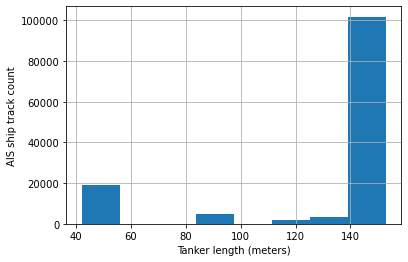

In [11]:
hist=sm_tankers.LENGTH.hist(weights=sm_tankers.MMSI_NUM, bins=8)
hist.set_ylabel('AIS ship track count')
hist.set_xlabel('Tanker length (meters)')

#### create histogram for all tanker lenghts and mmsi

Text(0.5, 0, 'Tanker length (meters)')

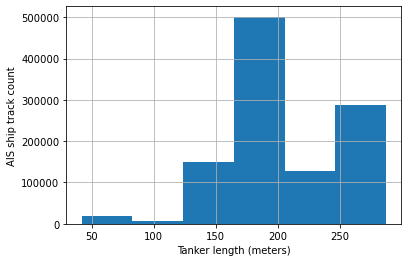

In [12]:
all_tankers = allTracks["tanker"][['LENGTH','MMSI_NUM']].groupby('LENGTH').count().sort_values(by='MMSI_NUM',ascending=False).reset_index()
hist=all_tankers.LENGTH.hist(weights=all_tankers.MMSI_NUM, bins=6)
hist.set_ylabel('AIS ship track count')
hist.set_xlabel('Tanker length (meters)')

In [13]:
all_tankers

,LENGTH,MMSI_NUM
0,183,319343
1,287,78666
2,273,64147
3,182,59741
4,144,47377
...,...,...
59,177,808
60,232,782
61,252,644
62,157,624


In [14]:
allTracks["tanker"][['LENGTH','MMSI_NUM']].groupby('LENGTH').last().sort_values(by='MMSI_NUM',ascending=False).reset_index()

,LENGTH,MMSI_NUM
0,232,636091469.0
1,250,636018579.0
2,183,636018092.0
3,244,636017858.0
4,277,636017061.0
...,...,...
59,275,240546000.0
60,195,238294000.0
61,252,232156000.0
62,176,219124000.0


#### Get representative MMSI for tanker lengths to look up in DOE database

In [15]:
allTracks["tanker"].loc[
    allTracks["tanker"]["LENGTH"]<155,
    ['LENGTH','MMSI_NUM']
].groupby('LENGTH').first()

,MMSI_NUM
LENGTH,
42,368009250.0
89,316041640.0
91,316014610.0
120,212744000.0
127,538006828.0
133,538005277.0
141,371823000.0
144,355320000.0
145,477173600.0


In [16]:
# MMSI 355320000.0 => KIRKEHOLMEN
K_df = DOEdf.loc[
    DOEdf.Receiver == 'KIRKEHOLMEN'
]
K_df.TransferQtyInGallon.max()

3990000.0

### max transfer to Kirkeholmen is 15,103,793.02 liters

In [17]:
tanker_list = DOEdf.loc[
    DOEdf.ReceiverTypeDescription == 'TANK SHIP',
    ['Receiver','ReceiverTypeDescription']
].groupby('Receiver').count().sort_values(by='ReceiverTypeDescription', ascending=False).reset_index()

In [18]:
tanker_list

,Receiver,ReceiverTypeDescription
0,KIRKEHOLMEN,91
1,OVERSEAS LOS ANGELES,76
2,PELICAN STATE,73
3,GLOBAL PROVIDER,37
4,AMERICAN FREEDOM,28
...,...,...
118,CHEMBULK WESTPORT,1
119,POMER,1
120,RS AURORA,1
121,BRITISH CHIEF,1


In [19]:
DOEdf.loc[
    DOEdf.Receiver == 'OVERSEAS LOS ANGELES',
    ['TransferQtyInGallon']
].max()

TransferQtyInGallon    11130000.0
dtype: float64

In [20]:
sf_df = DOEdf.loc[
    DOEdf.Receiver == 'SEAFRIEND'
]
sf_df.TransferQtyInGallon.max()

nan

In [21]:
tankerAntID={}
tankerAntID["out"] = DOEdf.loc[
    DOEdf.ReceiverTypeDescription == 'TANK SHIP',
    ['Receiver','ReceiverTypeDescription','TransferQtyInGallon','AntID']
].groupby('AntID').sum().sort_values(by='TransferQtyInGallon', ascending=False).reset_index()

## Create histogram of tanker lengths

In [22]:
from monte_carlo_utils import get_bin

bins = []
bins.append((0, 60))
bins.append((61, 150))
bins.append((151, 200))
bins.append((201, 250))
bins.append((251, 300))

size_classes = [
    "Smallest Tanker (< 60 m)",
    "Small Tanker (61 - 150 m)", 
    "Handymax (151-200 m)", 
    "Aframax (201-250 m)", 
    "SuezMax (251-300 m)" 
]
binned_data = numpy.zeros(len(bins))
binned_mmsi = pandas.DataFrame(columns = size_classes)
for idx,value in enumerate(allTracks["tanker"]["LENGTH"]):
    # accounting for no-data: -99999
    if value > 0:
        bin_index = get_bin(value, bins)  
        binned_data[bin_index] += 1    
#         if allTracks["tanker"]["MMSI_NUM"][idx] not in binned_mmsi[size_classes[bin_index]]:
#             binned_mmsi = binned_mmsi.append(
#                 {size_classes[bin_index]:allTracks["tanker"]["MMSI_NUM"][idx]},
#             ignore_index = True
#             )

0 19025.0
1 84730.0
2 572427.0
3 142846.0
4 272345.0


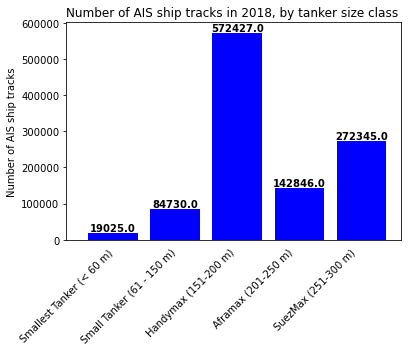

In [23]:
fig, ax = plt.subplots()    
#width = 0.75 # the width of the bars 
ind = numpy.arange(len(binned_data))  # the x locations for the groups
ax.bar(ind, binned_data, color="blue")
ax.set_xticks(ind-3/4)
ax.set_xticklabels(size_classes, minor=False, rotation=45)
ax.tick_params(axis = "x", which = "both", bottom = False, top = False)
plt.title('Number of AIS ship tracks in 2018, by tanker size class ')
#plt.xlabel('Tanker size class', rotation=45)
plt.ylabel('Number of AIS ship tracks')
for i, v in enumerate(binned_data):
    print(i,v)
    ax.text(i, v, str(v), color='black', fontweight='bold', ha='center', va='bottom')

In [24]:
size_classes

['Smallest Tanker (< 60 m)',
 'Small Tanker (61 - 150 m)',
 'Handymax (151-200 m)',
 'Aframax (201-250 m)',
 'SuezMax (251-300 m)']

In [25]:
binned_mmsi = {}
for idx,sizeclass in enumerate(size_classes):
    #print(idx,sizeclass)
    binned_mmsi[sizeclass]= allTracks["tanker"].loc[
        (allTracks["tanker"]["LENGTH"] > bins[idx][0]) & 
        (allTracks["tanker"]["LENGTH"] < bins[idx][1]),
        ['MMSI_NUM','LENGTH']
    ].groupby('MMSI_NUM').count().sort_values(by='LENGTH',ascending=False).rename(columns={'LENGTH':'COUNT'})
    print(sizeclass)
    print(binned_mmsi[sizeclass])

Smallest Tanker (< 60 m)
             COUNT
MMSI_NUM          
368009250.0  19025
Small Tanker (61 - 150 m)
             COUNT
MMSI_NUM          
355320000.0  33381
566306000.0   6427
477636500.0   6416
477493700.0   5874
316014610.0   4715
477173600.0   4299
373353000.0   4129
538006371.0   3472
351456000.0   2695
371823000.0   2408
357299000.0   1911
538005277.0   1869
212744000.0   1726
477229900.0   1703
538006828.0   1582
373474000.0   1376
538003481.0    336
372405000.0    319
316041640.0     92
Handymax (151-200 m)
             COUNT
MMSI_NUM          
369042000.0  41383
367353110.0  37996
366855000.0  32830
367134000.0  31026
369040000.0  26513
...            ...
563654000.0    229
371394000.0    213
538006805.0    166
477858900.0     51
257005000.0     48

[140 rows x 1 columns]
Aframax (201-250 m)
             COUNT
MMSI_NUM          
636015178.0   6057
220518000.0   5718
255806154.0   5140
311943000.0   4609
538001893.0   4172
...            ...
538002946.0    698
309038000.

## Find vessel names for mmsi through myshiptracking.com

In [32]:
mmsi_names = {368009250:"GLOBAL PROVIDER",
    355320000:"KIRKEHOLMEN",
    369042000:"AMERICAN FREEDOM",
    367353110:"PELICAN STATE", 
    636015178:"AQUALEGACY",
    220518000:"TORM EMILIE",
    303294000:"ALASKAN EXPLORER",
    367688000:"ALASKAN NAVIGATOR"}
mmsi_sizeclass = {368009250:"Smallest Tanker (< 60 m)",
    355320000:"Small Tanker (61 - 150 m)",
    369042000:"Handymax (151-200 m)",
    367353110:"Handymax (151-200 m)", 
    636015178:"Aframax (201-250 m)",
    220518000:"Aframax (201-250 m)",
    303294000:"SuezMax (251-300 m)",
    367688000:"SuezMax (251-300 m)"}

## Search DOE for names and return max transfer volume

In [27]:
[*mmsi_names]

[368009250,
 355320000,
 369042000,
 367353110,
 636015178,
 220518000,
 303294000,
 367688000]

## Loop through each mmsi and get max transfer volume for AntID

In [47]:
export_by_vessel = {}
import_by_vessel = {}
print('~~~ EXPORTS ~~~')
print('mmsi', '\t max transfer volume (liters)','size class')
gal2liter = 3.78541
for idx,mmsi in enumerate([*mmsi_names]):    
    export_by_vessel[mmsi_names[mmsi]] = DOEdf.loc[
        DOEdf.Receiver == mmsi_names[mmsi],
        ['TransferQtyInGallon','AntID','StartDateTime']
    ].groupby('AntID').agg(
        {'TransferQtyInGallon':'max','StartDateTime':'first'}
    ).sort_values(by='TransferQtyInGallon',ascending=False)
    #print out max transfer volume for mmsi
    print(mmsi, 
          f'{gal2liter*max(export_by_vessel[mmsi_names[mmsi]]["TransferQtyInGallon"]):.2e}\t',
         mmsi_sizeclass[mmsi])
print('~~~ IMPORTS ~~~')
for idx,mmsi in enumerate([*mmsi_names]):    
    import_by_vessel[mmsi_names[mmsi]] = DOEdf.loc[
        DOEdf.Deliverer == mmsi_names[mmsi],
        ['TransferQtyInGallon','AntID','StartDateTime']
    ].groupby('AntID').agg(
        {'TransferQtyInGallon':'max','StartDateTime':'first'}
    ).sort_values(by='TransferQtyInGallon',ascending=False)
    #print out max transfer volume for mmsi
    if not import_by_vessel[mmsi_names[mmsi]]["TransferQtyInGallon"].empty:
        print(mmsi, 
              f'{gal2liter*max(import_by_vessel[mmsi_names[mmsi]]["TransferQtyInGallon"]):.2e}\t',
             mmsi_sizeclass[mmsi])

~~~ EXPORTS ~~~
mmsi 	 max transfer volume (liters) size class
368009250 5.88e+05	 Smallest Tanker (< 60 m)
355320000 1.51e+07	 Small Tanker (61 - 150 m)
369042000 2.38e+07	 Handymax (151-200 m)
367353110 3.82e+07	 Handymax (151-200 m)
636015178 1.08e+06	 Aframax (201-250 m)
220518000 5.90e+07	 Aframax (201-250 m)
303294000 2.36e+06	 SuezMax (251-300 m)
367688000 4.77e+07	 SuezMax (251-300 m)
~~~ IMPORTS ~~~
368009250 5.87e+05	 Smallest Tanker (< 60 m)
369042000 3.02e+07	 Handymax (151-200 m)
367353110 1.91e+07	 Handymax (151-200 m)
636015178 3.18e+07	 Aframax (201-250 m)
220518000 7.95e+07	 Aframax (201-250 m)
303294000 1.43e+08	 SuezMax (251-300 m)
367688000 1.43e+08	 SuezMax (251-300 m)


## NEXT:
1. compare with cargo capacity
- ship typecargo capacity (liters)
- smallest tanker	588,253
- small tanker	15103793.00
- handymax	53000000.00
- aframax	126211000.00
- suezmax	185447000.00

2. Get maximum cargo transfer value to make sure it matches our SuezMax value